In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn.pool import knn_graph
import random

In [2]:
num_nodes = 5
num_node_features = 10
x = torch.randn(num_nodes, num_node_features)
print(x)

tensor([[ 0.0431,  0.4018, -0.2852,  0.5245, -0.8299,  2.1720, -1.1246, -1.1298,
          0.1497, -0.3644],
        [-2.1516, -1.1698,  0.2321,  1.3582, -1.6424,  1.0983,  1.0036,  0.7838,
         -0.8078, -0.2821],
        [ 0.1954, -0.2114,  0.7121, -1.5373,  0.0194,  0.5222,  1.0667, -0.8864,
          0.7094,  1.0767],
        [-0.0492, -1.8754, -0.6015,  1.6571, -1.5406,  0.8120, -0.4853, -0.4960,
          0.4934, -2.3923],
        [ 0.2361, -0.1554,  0.1785,  0.5096,  1.6501, -0.4125, -0.0523,  0.3316,
          0.6468, -0.3803]])


In [3]:
pos = torch.randn(num_nodes, 2)
print(pos)

tensor([[-0.2451,  0.3019],
        [-0.9627, -0.9223],
        [-0.5598, -0.6906],
        [ 0.6714,  0.8701],
        [-0.9068, -1.4321]])


In [4]:
edge_index = knn_graph(pos, k=4, loop=False)

In [5]:
y = x.sum(dim=1).mean().unsqueeze(0)

data = Data(x=x, edge_index=edge_index, pos=pos, y=y)

In [6]:
print(data.pos)

tensor([[-0.2451,  0.3019],
        [-0.9627, -0.9223],
        [-0.5598, -0.6906],
        [ 0.6714,  0.8701],
        [-0.9068, -1.4321]])


### visualizing geometric data object as a networkx graph

In [7]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

In [8]:
G = to_networkx(data,to_undirected=True,node_attrs=['x'],edge_attrs=None)

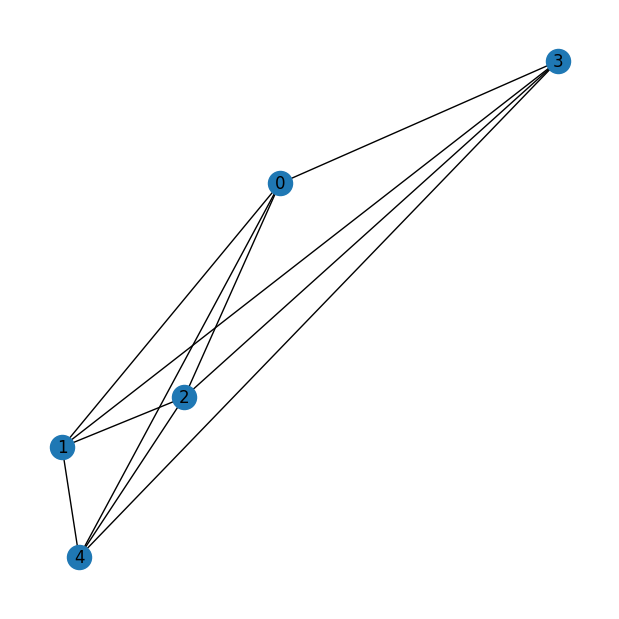

In [9]:
# the position helps to visualize the true graph. If pos is not passed to nx.draw, we lose information on 
# the position of the nodes (see the cell below this)
pos = {i: data.pos[i].tolist() for i in range(data.num_nodes)}

plt.figure(figsize=(6, 6))
nx.draw(G,pos,node_size=300,with_labels=True)
plt.show()

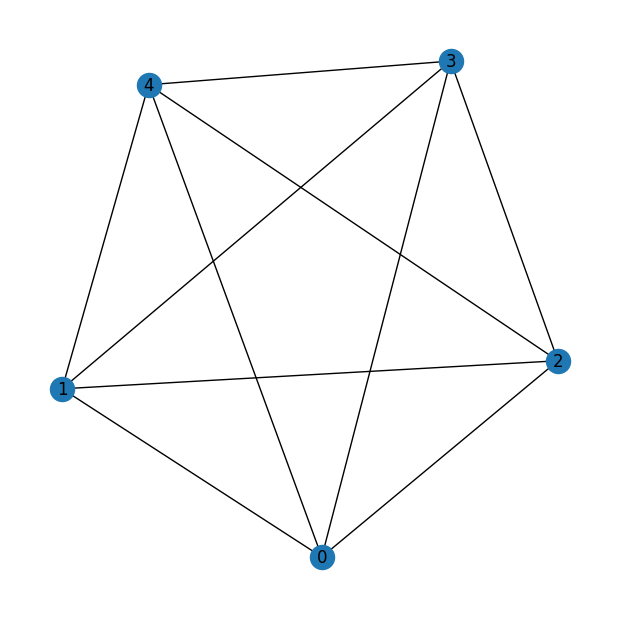

In [10]:
# this will give a neat graph 
plt.figure(figsize=(6, 6))
nx.draw(G,node_size=300,with_labels=True)
plt.show()

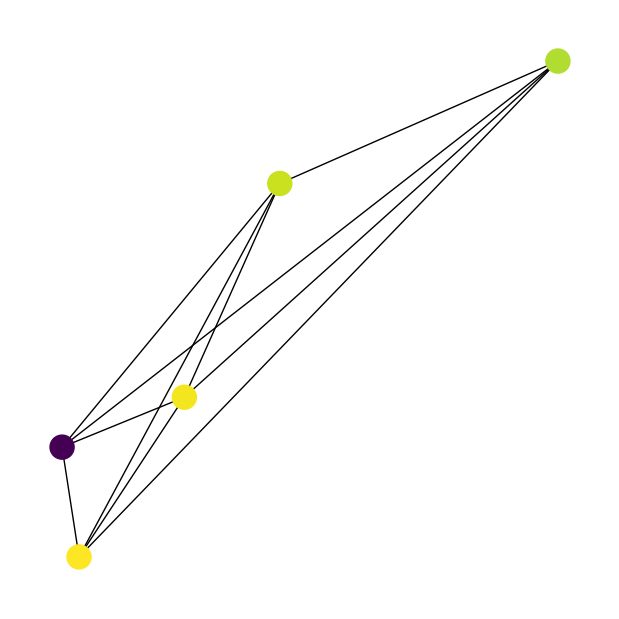

In [11]:
node_colors = data.x[:, 0].numpy()

plt.figure(figsize=(6, 6))
nx.draw(G,pos,node_color=node_colors,node_size=300,with_labels=False)
# plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'))
plt.show()


In [12]:
def create_random_graph(min_nodes=5, max_nodes=30, num_node_features=10, k=4):
    num_nodes = random.randint(min_nodes, max_nodes)

    x = torch.randn(num_nodes, num_node_features)

    pos = torch.randn(num_nodes, 2)

    edge_index = knn_graph(pos, k=k, loop=False)

    y = x.sum(dim=1).mean().unsqueeze(0)

    return Data(
        x=x,
        edge_index=edge_index,
        pos=pos,
        y=y
    )

In [13]:
def create_dataset(num_graphs=1000):
    dataset = []
    for _ in range(num_graphs):
        graph = create_random_graph()
        dataset.append(graph)
    return dataset

In [14]:
dataset = create_dataset(300)

In [15]:
print()
# print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset[0].x.shape[1]}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Number of graphs: 300
Number of features: 10

Data(x=[30, 10], edge_index=[2, 120], y=[1], pos=[30, 2])
Number of nodes: 30
Number of edges: 120
Average node degree: 4.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [16]:
def plot_geometric_data_as_graph(data):
    G = to_networkx(data, to_undirected=True, node_attrs=['x'], edge_attrs=None)
    pos = {i: data.pos[i].tolist() for i in range(data.num_nodes)}
    fig = plt.figure(figsize=(6, 6))
    nx.draw(G,pos,node_size=300,with_labels=False)
    plt.show()
    fig.clear()

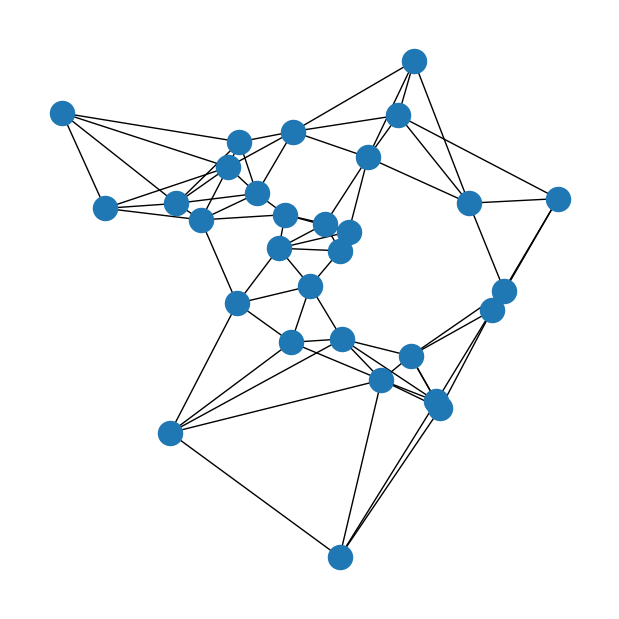

In [17]:
plot_geometric_data_as_graph(dataset[10])

### Splitting the dataset in to train and test dataset

In [18]:
train_dataset = dataset[:200]
val_dataset = dataset[200:260]
test_dataset = dataset[260:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 200
Number of validation graphs: 60
Number of test graphs: 40


In [25]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[1116, 10], edge_index=[2, 4464], y=[64], pos=[1116, 2], batch=[1116], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[1108, 10], edge_index=[2, 4432], y=[64], pos=[1108, 2], batch=[1108], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[1082, 10], edge_index=[2, 4328], y=[64], pos=[1082, 2], batch=[1082], ptr=[65])

Step 4:
Number of graphs in the current batch: 8
DataBatch(x=[147, 10], edge_index=[2, 588], y=[8], pos=[147, 2], batch=[147], ptr=[9])



In [26]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCNRegressor(torch.nn.Module):
    def __init__(self, num_node_features,hidden_channels):
        super(GCNRegressor, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin(x)
        
        return x

In [27]:
model = GCNRegressor(num_node_features=10,hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

In [38]:
def train():
    model.train()
    mse_total = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad() # Clear gradients.
        mse_value = F.mse_loss(out, data.y)
        mse_total+=mse_value
        print(f'{out=}')
        print(f'{data.y-out}')
        return mse_total / len(train_loader.dataset), out, loss

def test(loader):
    model.eval()
    mse_total = 0
    with torch.no_grad():
        for data in loader:  # Iterate in batches over the training/test dataset.
            out = model(data.x, data.edge_index, data.batch)  
            pred = out  # Use the class with highest probability.
            mse_value = F.mse_loss(pred, data.y)
            mse_total+=mse_value
    #         print(pred)
    #         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return mse_total / len(loader.dataset)  # Derive ratio of correct predictions.

In [39]:
train_mse = []
val_mse = []
test_mse = []
for epoch in range(1, 100):
    train_mse_epoch, out, loss = train()
    train_mse.append(train_mse_epoch)
    
#     train_mse = test(train_loader)
    val_mse_epoch = test(val_loader)
    val_mse.append(val_mse_epoch)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train MSE: {train_mse_epoch:.4f}, Validation MSE: {val_mse_epoch:.4f}')
#     print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

C:\Users\akash\AppData\Local\Temp\ipykernel_8916\3804072629.py:10: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_value = F.mse_loss(out, data.y)
C:\Users\akash\AppData\Local\Temp\ipykernel_8916\3804072629.py:23: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_value = F.mse_loss(pred, data.y)


out=tensor([[-0.0099],
        [-0.0100],
        [-0.0100],
        [-0.0100],
        [-0.0101],
        [-0.0101],
        [-0.0099],
        [-0.0100],
        [-0.0099],
        [-0.0098],
        [-0.0099],
        [-0.0100],
        [-0.0100],
        [-0.0100],
        [-0.0098],
        [-0.0101],
        [-0.0102],
        [-0.0098],
        [-0.0101],
        [-0.0101],
        [-0.0100],
        [-0.0100],
        [-0.0100],
        [-0.0100],
        [-0.0100],
        [-0.0101],
        [-0.0101],
        [-0.0099],
        [-0.0099],
        [-0.0098],
        [-0.0097],
        [-0.0100],
        [-0.0099],
        [-0.0100],
        [-0.0100],
        [-0.0098],
        [-0.0101],
        [-0.0100],
        [-0.0099],
        [-0.0100],
        [-0.0102],
        [-0.0101],
        [-0.0100],
        [-0.0100],
        [-0.0100],
        [-0.0102],
        [-0.0100],
        [-0.0100],
        [-0.0100],
        [-0.0100],
        [-0.0101],
        [-0.0100],
        

out=tensor([[-0.0213],
        [-0.0214],
        [-0.0211],
        [-0.0213],
        [-0.0216],
        [-0.0214],
        [-0.0214],
        [-0.0215],
        [-0.0215],
        [-0.0214],
        [-0.0217],
        [-0.0213],
        [-0.0214],
        [-0.0215],
        [-0.0216],
        [-0.0216],
        [-0.0215],
        [-0.0216],
        [-0.0215],
        [-0.0214],
        [-0.0216],
        [-0.0214],
        [-0.0217],
        [-0.0212],
        [-0.0216],
        [-0.0212],
        [-0.0216],
        [-0.0213],
        [-0.0216],
        [-0.0215],
        [-0.0215],
        [-0.0214],
        [-0.0213],
        [-0.0214],
        [-0.0216],
        [-0.0215],
        [-0.0214],
        [-0.0213],
        [-0.0216],
        [-0.0214],
        [-0.0213],
        [-0.0215],
        [-0.0215],
        [-0.0214],
        [-0.0214],
        [-0.0214],
        [-0.0216],
        [-0.0216],
        [-0.0215],
        [-0.0213],
        [-0.0214],
        [-0.0216],
        

out=tensor([[-0.0152],
        [-0.0153],
        [-0.0155],
        [-0.0155],
        [-0.0154],
        [-0.0153],
        [-0.0152],
        [-0.0156],
        [-0.0153],
        [-0.0151],
        [-0.0152],
        [-0.0153],
        [-0.0154],
        [-0.0154],
        [-0.0155],
        [-0.0155],
        [-0.0152],
        [-0.0154],
        [-0.0155],
        [-0.0156],
        [-0.0154],
        [-0.0154],
        [-0.0154],
        [-0.0151],
        [-0.0154],
        [-0.0156],
        [-0.0154],
        [-0.0155],
        [-0.0155],
        [-0.0158],
        [-0.0153],
        [-0.0152],
        [-0.0154],
        [-0.0153],
        [-0.0155],
        [-0.0156],
        [-0.0154],
        [-0.0154],
        [-0.0154],
        [-0.0153],
        [-0.0154],
        [-0.0153],
        [-0.0153],
        [-0.0156],
        [-0.0155],
        [-0.0153],
        [-0.0153],
        [-0.0154],
        [-0.0153],
        [-0.0155],
        [-0.0152],
        [-0.0153],
        

out=tensor([[0.0109],
        [0.0110],
        [0.0104],
        [0.0102],
        [0.0111],
        [0.0110],
        [0.0101],
        [0.0111],
        [0.0099],
        [0.0108],
        [0.0101],
        [0.0106],
        [0.0105],
        [0.0107],
        [0.0090],
        [0.0104],
        [0.0084],
        [0.0103],
        [0.0086],
        [0.0107],
        [0.0111],
        [0.0110],
        [0.0084],
        [0.0105],
        [0.0097],
        [0.0111],
        [0.0105],
        [0.0112],
        [0.0109],
        [0.0094],
        [0.0095],
        [0.0112],
        [0.0109],
        [0.0103],
        [0.0108],
        [0.0089],
        [0.0111],
        [0.0091],
        [0.0110],
        [0.0112],
        [0.0103],
        [0.0076],
        [0.0108],
        [0.0109],
        [0.0111],
        [0.0096],
        [0.0108],
        [0.0111],
        [0.0092],
        [0.0093],
        [0.0104],
        [0.0112],
        [0.0097],
        [0.0099],
        [0.0107],
      

Epoch: 021, Loss: 0.4293, Train MSE: 0.0021, Validation MSE: 0.0130
out=tensor([[0.0380],
        [0.0397],
        [0.0341],
        [0.0374],
        [0.0315],
        [0.0398],
        [0.0323],
        [0.0375],
        [0.0398],
        [0.0396],
        [0.0299],
        [0.0373],
        [0.0382],
        [0.0318],
        [0.0351],
        [0.0354],
        [0.0364],
        [0.0316],
        [0.0327],
        [0.0396],
        [0.0398],
        [0.0355],
        [0.0398],
        [0.0389],
        [0.0365],
        [0.0364],
        [0.0331],
        [0.0341],
        [0.0351],
        [0.0379],
        [0.0307],
        [0.0366],
        [0.0398],
        [0.0397],
        [0.0396],
        [0.0372],
        [0.0396],
        [0.0400],
        [0.0351],
        [0.0396],
        [0.0389],
        [0.0308],
        [0.0390],
        [0.0389],
        [0.0398],
        [0.0398],
        [0.0398],
        [0.0395],
        [0.0387],
        [0.0395],
        [0.0397],
        [0

Epoch: 026, Loss: 0.6486, Train MSE: 0.0032, Validation MSE: 0.0129
out=tensor([[0.0514],
        [0.0556],
        [0.0555],
        [0.0511],
        [0.0590],
        [0.0594],
        [0.0591],
        [0.0506],
        [0.0540],
        [0.0519],
        [0.0578],
        [0.0550],
        [0.0591],
        [0.0464],
        [0.0480],
        [0.0590],
        [0.0575],
        [0.0576],
        [0.0575],
        [0.0539],
        [0.0540],
        [0.0555],
        [0.0555],
        [0.0469],
        [0.0589],
        [0.0564],
        [0.0590],
        [0.0590],
        [0.0493],
        [0.0590],
        [0.0546],
        [0.0550],
        [0.0453],
        [0.0590],
        [0.0562],
        [0.0505],
        [0.0592],
        [0.0415],
        [0.0576],
        [0.0454],
        [0.0576],
        [0.0591],
        [0.0562],
        [0.0480],
        [0.0590],
        [0.0541],
        [0.0514],
        [0.0483],
        [0.0591],
        [0.0518],
        [0.0524],
        [0

Epoch: 032, Loss: 0.7672, Train MSE: 0.0038, Validation MSE: 0.0129
out=tensor([[0.0491],
        [0.0499],
        [0.0523],
        [0.0509],
        [0.0488],
        [0.0468],
        [0.0499],
        [0.0525],
        [0.0511],
        [0.0521],
        [0.0499],
        [0.0520],
        [0.0488],
        [0.0479],
        [0.0480],
        [0.0506],
        [0.0519],
        [0.0479],
        [0.0511],
        [0.0520],
        [0.0490],
        [0.0489],
        [0.0517],
        [0.0470],
        [0.0517],
        [0.0517],
        [0.0510],
        [0.0492],
        [0.0485],
        [0.0474],
        [0.0522],
        [0.0464],
        [0.0518],
        [0.0436],
        [0.0489],
        [0.0465],
        [0.0457],
        [0.0514],
        [0.0521],
        [0.0499],
        [0.0519],
        [0.0494],
        [0.0503],
        [0.0498],
        [0.0481],
        [0.0488],
        [0.0489],
        [0.0524],
        [0.0476],
        [0.0474],
        [0.0489],
        [0

Epoch: 037, Loss: 0.4703, Train MSE: 0.0024, Validation MSE: 0.0130
out=tensor([[0.0374],
        [0.0372],
        [0.0374],
        [0.0391],
        [0.0395],
        [0.0382],
        [0.0360],
        [0.0381],
        [0.0374],
        [0.0374],
        [0.0392],
        [0.0375],
        [0.0388],
        [0.0378],
        [0.0390],
        [0.0381],
        [0.0389],
        [0.0371],
        [0.0370],
        [0.0388],
        [0.0387],
        [0.0384],
        [0.0368],
        [0.0367],
        [0.0363],
        [0.0389],
        [0.0379],
        [0.0380],
        [0.0371],
        [0.0391],
        [0.0386],
        [0.0378],
        [0.0379],
        [0.0388],
        [0.0379],
        [0.0388],
        [0.0384],
        [0.0387],
        [0.0367],
        [0.0382],
        [0.0368],
        [0.0364],
        [0.0387],
        [0.0389],
        [0.0382],
        [0.0372],
        [0.0383],
        [0.0388],
        [0.0380],
        [0.0383],
        [0.0382],
        [0

Epoch: 042, Loss: 0.7073, Train MSE: 0.0035, Validation MSE: 0.0130
out=tensor([[0.0295],
        [0.0280],
        [0.0290],
        [0.0294],
        [0.0297],
        [0.0295],
        [0.0287],
        [0.0304],
        [0.0311],
        [0.0290],
        [0.0302],
        [0.0293],
        [0.0290],
        [0.0289],
        [0.0292],
        [0.0282],
        [0.0283],
        [0.0292],
        [0.0283],
        [0.0288],
        [0.0294],
        [0.0285],
        [0.0299],
        [0.0290],
        [0.0292],
        [0.0285],
        [0.0289],
        [0.0291],
        [0.0285],
        [0.0287],
        [0.0287],
        [0.0294],
        [0.0296],
        [0.0289],
        [0.0283],
        [0.0289],
        [0.0283],
        [0.0292],
        [0.0296],
        [0.0300],
        [0.0293],
        [0.0282],
        [0.0303],
        [0.0291],
        [0.0293],
        [0.0290],
        [0.0285],
        [0.0286],
        [0.0285],
        [0.0305],
        [0.0283],
        [0

Epoch: 048, Loss: 1.0461, Train MSE: 0.0052, Validation MSE: 0.0132
out=tensor([[-0.0065],
        [-0.0036],
        [-0.0016],
        [-0.0043],
        [-0.0076],
        [-0.0073],
        [-0.0069],
        [-0.0050],
        [-0.0072],
        [-0.0052],
        [-0.0022],
        [-0.0009],
        [-0.0071],
        [-0.0082],
        [-0.0010],
        [-0.0052],
        [-0.0068],
        [-0.0068],
        [-0.0074],
        [ 0.0015],
        [-0.0072],
        [-0.0048],
        [-0.0057],
        [-0.0061],
        [-0.0016],
        [ 0.0006],
        [-0.0028],
        [ 0.0023],
        [-0.0037],
        [-0.0067],
        [-0.0031],
        [ 0.0012],
        [-0.0072],
        [ 0.0013],
        [-0.0050],
        [-0.0033],
        [-0.0027],
        [ 0.0030],
        [-0.0023],
        [-0.0056],
        [-0.0011],
        [ 0.0058],
        [ 0.0055],
        [-0.0051],
        [-0.0018],
        [-0.0034],
        [-0.0072],
        [ 0.0001],
        [-0.0066

Epoch: 053, Loss: 0.6378, Train MSE: 0.0032, Validation MSE: 0.0133
out=tensor([[-0.0255],
        [-0.0281],
        [-0.0240],
        [-0.0313],
        [-0.0330],
        [-0.0283],
        [-0.0116],
        [-0.0322],
        [-0.0324],
        [-0.0222],
        [-0.0320],
        [-0.0211],
        [-0.0293],
        [-0.0249],
        [-0.0242],
        [-0.0260],
        [-0.0213],
        [-0.0320],
        [-0.0299],
        [-0.0236],
        [-0.0260],
        [-0.0219],
        [-0.0239],
        [-0.0281],
        [-0.0280],
        [-0.0317],
        [-0.0187],
        [-0.0221],
        [-0.0268],
        [-0.0277],
        [-0.0305],
        [-0.0291],
        [-0.0301],
        [-0.0308],
        [-0.0209],
        [-0.0282],
        [-0.0261],
        [-0.0283],
        [-0.0230],
        [-0.0191],
        [-0.0279],
        [-0.0296],
        [-0.0312],
        [-0.0269],
        [-0.0202],
        [-0.0214],
        [-0.0198],
        [-0.0303],
        [-0.0278

Epoch: 059, Loss: 0.7099, Train MSE: 0.0035, Validation MSE: 0.0132
out=tensor([[-0.0030],
        [-0.0054],
        [-0.0090],
        [-0.0062],
        [-0.0085],
        [-0.0081],
        [-0.0067],
        [-0.0079],
        [-0.0048],
        [-0.0094],
        [-0.0041],
        [-0.0052],
        [-0.0096],
        [-0.0087],
        [-0.0080],
        [-0.0080],
        [-0.0051],
        [-0.0097],
        [-0.0048],
        [-0.0083],
        [-0.0085],
        [-0.0105],
        [-0.0002],
        [-0.0089],
        [-0.0117],
        [-0.0104],
        [-0.0073],
        [-0.0085],
        [-0.0081],
        [-0.0093],
        [-0.0076],
        [-0.0074],
        [-0.0018],
        [-0.0085],
        [-0.0040],
        [-0.0098],
        [-0.0041],
        [-0.0073],
        [-0.0065],
        [-0.0090],
        [-0.0086],
        [-0.0070],
        [-0.0054],
        [-0.0070],
        [-0.0094],
        [-0.0086],
        [-0.0087],
        [-0.0091],
        [-0.0039

out=tensor([[0.0218],
        [0.0204],
        [0.0188],
        [0.0207],
        [0.0221],
        [0.0203],
        [0.0240],
        [0.0238],
        [0.0244],
        [0.0212],
        [0.0239],
        [0.0234],
        [0.0227],
        [0.0195],
        [0.0235],
        [0.0235],
        [0.0239],
        [0.0217],
        [0.0202],
        [0.0148],
        [0.0192],
        [0.0222],
        [0.0194],
        [0.0238],
        [0.0237],
        [0.0193],
        [0.0180],
        [0.0235],
        [0.0238],
        [0.0183],
        [0.0218],
        [0.0217],
        [0.0191],
        [0.0238],
        [0.0240],
        [0.0237],
        [0.0216],
        [0.0224],
        [0.0208],
        [0.0226],
        [0.0224],
        [0.0228],
        [0.0240],
        [0.0166],
        [0.0243],
        [0.0196],
        [0.0195],
        [0.0236],
        [0.0211],
        [0.0189],
        [0.0200],
        [0.0235],
        [0.0238],
        [0.0170],
        [0.0242],
      

out=tensor([[0.0306],
        [0.0253],
        [0.0305],
        [0.0275],
        [0.0191],
        [0.0313],
        [0.0313],
        [0.0316],
        [0.0277],
        [0.0242],
        [0.0316],
        [0.0295],
        [0.0281],
        [0.0316],
        [0.0316],
        [0.0263],
        [0.0294],
        [0.0220],
        [0.0316],
        [0.0284],
        [0.0283],
        [0.0285],
        [0.0282],
        [0.0296],
        [0.0262],
        [0.0231],
        [0.0315],
        [0.0293],
        [0.0313],
        [0.0315],
        [0.0287],
        [0.0293],
        [0.0317],
        [0.0294],
        [0.0286],
        [0.0315],
        [0.0295],
        [0.0303],
        [0.0282],
        [0.0316],
        [0.0313],
        [0.0316],
        [0.0232],
        [0.0313],
        [0.0243],
        [0.0285],
        [0.0211],
        [0.0263],
        [0.0284],
        [0.0305],
        [0.0211],
        [0.0281],
        [0.0316],
        [0.0314],
        [0.0296],
      

out=tensor([[0.0278],
        [0.0269],
        [0.0234],
        [0.0219],
        [0.0296],
        [0.0257],
        [0.0294],
        [0.0233],
        [0.0286],
        [0.0287],
        [0.0278],
        [0.0293],
        [0.0297],
        [0.0270],
        [0.0232],
        [0.0297],
        [0.0218],
        [0.0296],
        [0.0296],
        [0.0293],
        [0.0250],
        [0.0247],
        [0.0207],
        [0.0248],
        [0.0276],
        [0.0280],
        [0.0293],
        [0.0226],
        [0.0289],
        [0.0297],
        [0.0259],
        [0.0295],
        [0.0299],
        [0.0217],
        [0.0294],
        [0.0288],
        [0.0229],
        [0.0242],
        [0.0247],
        [0.0271],
        [0.0246],
        [0.0293],
        [0.0226],
        [0.0269],
        [0.0286],
        [0.0295],
        [0.0299],
        [0.0295],
        [0.0268],
        [0.0258],
        [0.0265],
        [0.0276],
        [0.0284],
        [0.0275],
        [0.0294],
      

out=tensor([[0.0260],
        [0.0220],
        [0.0239],
        [0.0250],
        [0.0259],
        [0.0193],
        [0.0215],
        [0.0204],
        [0.0256],
        [0.0222],
        [0.0235],
        [0.0252],
        [0.0256],
        [0.0248],
        [0.0206],
        [0.0213],
        [0.0228],
        [0.0238],
        [0.0261],
        [0.0198],
        [0.0255],
        [0.0248],
        [0.0225],
        [0.0223],
        [0.0258],
        [0.0248],
        [0.0236],
        [0.0256],
        [0.0253],
        [0.0180],
        [0.0211],
        [0.0197],
        [0.0257],
        [0.0262],
        [0.0241],
        [0.0211],
        [0.0225],
        [0.0239],
        [0.0246],
        [0.0245],
        [0.0195],
        [0.0214],
        [0.0212],
        [0.0226],
        [0.0188],
        [0.0202],
        [0.0233],
        [0.0204],
        [0.0216],
        [0.0238],
        [0.0255],
        [0.0219],
        [0.0239],
        [0.0242],
        [0.0215],
      

out=tensor([[0.0117],
        [0.0134],
        [0.0096],
        [0.0132],
        [0.0148],
        [0.0110],
        [0.0130],
        [0.0145],
        [0.0117],
        [0.0139],
        [0.0151],
        [0.0113],
        [0.0111],
        [0.0114],
        [0.0148],
        [0.0134],
        [0.0135],
        [0.0108],
        [0.0151],
        [0.0120],
        [0.0138],
        [0.0151],
        [0.0131],
        [0.0140],
        [0.0139],
        [0.0134],
        [0.0147],
        [0.0127],
        [0.0154],
        [0.0132],
        [0.0136],
        [0.0137],
        [0.0138],
        [0.0141],
        [0.0105],
        [0.0133],
        [0.0134],
        [0.0105],
        [0.0145],
        [0.0126],
        [0.0134],
        [0.0148],
        [0.0133],
        [0.0138],
        [0.0126],
        [0.0130],
        [0.0120],
        [0.0157],
        [0.0133],
        [0.0150],
        [0.0119],
        [0.0118],
        [0.0134],
        [0.0136],
        [0.0135],
      

Epoch: 092, Loss: 0.7303, Train MSE: 0.0037, Validation MSE: 0.0131
out=tensor([[0.0077],
        [0.0095],
        [0.0084],
        [0.0087],
        [0.0078],
        [0.0106],
        [0.0073],
        [0.0077],
        [0.0100],
        [0.0082],
        [0.0083],
        [0.0095],
        [0.0085],
        [0.0086],
        [0.0063],
        [0.0076],
        [0.0061],
        [0.0058],
        [0.0088],
        [0.0083],
        [0.0087],
        [0.0078],
        [0.0094],
        [0.0076],
        [0.0087],
        [0.0074],
        [0.0084],
        [0.0067],
        [0.0087],
        [0.0077],
        [0.0070],
        [0.0070],
        [0.0069],
        [0.0068],
        [0.0080],
        [0.0085],
        [0.0088],
        [0.0092],
        [0.0074],
        [0.0078],
        [0.0089],
        [0.0114],
        [0.0105],
        [0.0101],
        [0.0075],
        [0.0086],
        [0.0082],
        [0.0084],
        [0.0080],
        [0.0078],
        [0.0083],
        [0

Epoch: 097, Loss: 0.6085, Train MSE: 0.0030, Validation MSE: 0.0131
out=tensor([[0.0130],
        [0.0125],
        [0.0127],
        [0.0131],
        [0.0135],
        [0.0129],
        [0.0147],
        [0.0131],
        [0.0132],
        [0.0133],
        [0.0105],
        [0.0136],
        [0.0118],
        [0.0107],
        [0.0132],
        [0.0132],
        [0.0152],
        [0.0129],
        [0.0150],
        [0.0130],
        [0.0134],
        [0.0129],
        [0.0132],
        [0.0137],
        [0.0127],
        [0.0121],
        [0.0111],
        [0.0137],
        [0.0139],
        [0.0132],
        [0.0129],
        [0.0150],
        [0.0130],
        [0.0131],
        [0.0125],
        [0.0141],
        [0.0147],
        [0.0134],
        [0.0139],
        [0.0122],
        [0.0131],
        [0.0138],
        [0.0133],
        [0.0119],
        [0.0137],
        [0.0143],
        [0.0147],
        [0.0105],
        [0.0144],
        [0.0146],
        [0.0135],
        [0